#                                                                                    <h1><center>NBME</center></h1> 


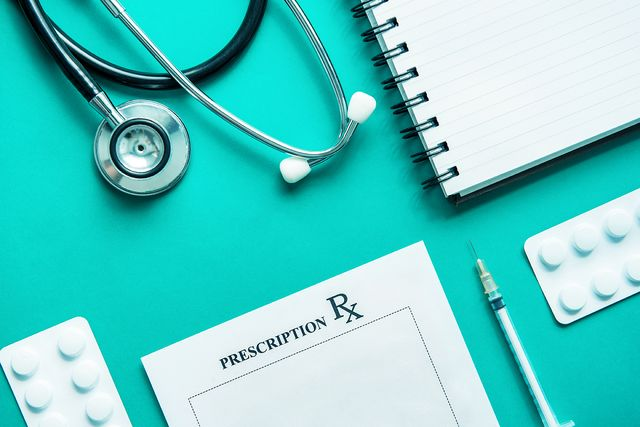
- ## Problem Statement

When you visit a doctor, how they interpret your symptoms can determine whether your diagnosis is accurate. By the time they’re licensed, physicians have had a lot of practice writing patient notes that document the history of the patient’s complaint, physical exam findings, possible diagnoses, and follow-up care. Learning and assessing the skill of writing patient notes requires feedback from other doctors, a time-intensive process that could be improved with the addition of machine learning.

Until recently, the Step 2 Clinical Skills examination was one component of the United States Medical Licensing Examination® (USMLE®). The exam required test-takers to interact with Standardized Patients (people trained to portray specific clinical cases) and write a patient note. Trained physician raters later scored patient notes with rubrics that outlined each case’s important concepts (referred to as features). The more such features found in a patient note, the higher the score (among other factors that contribute to the final score for the exam).

However, having physicians score patient note exams requires significant time, along with human and financial resources. Approaches using natural language processing have been created to address this problem, but patient notes can still be challenging to score computationally because features may be expressed in many ways. For example, the feature "loss of interest in activities" can be expressed as "no longer plays tennis." Other challenges include the need to map concepts by combining multiple text segments, or cases of ambiguous negation such as “no cold intolerance, hair loss, palpitations, or tremor” corresponding to the key essential “lack of other thyroid symptoms.”

In this competition, you’ll identify specific clinical concepts in patient notes. Specifically, you'll develop an automated method to map clinical concepts from an exam rubric (e.g., “diminished appetite”) to various ways in which these concepts are expressed in clinical patient notes written by medical students (e.g., “eating less,” “clothes fit looser”). Great solutions will be both accurate and reliable.

- ## Objective 
The objective of this notbook is to undersstand the the data.

Inspiration: https://www.kaggle.com/odins0n/nbme-detailed-eda

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns

import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import string

import plotly.express as px
import plotly.graph_objects as go

from IPython.display import Image

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
train = pd.read_csv("../input/nbme-score-clinical-patient-notes/train.csv")
test = pd.read_csv("../input/nbme-score-clinical-patient-notes/test.csv")
features = pd.read_csv("../input/nbme-score-clinical-patient-notes/features.csv")
patient_notes = pd.read_csv("../input/nbme-score-clinical-patient-notes/patient_notes.csv")
submission = pd.read_csv("../input/nbme-score-clinical-patient-notes/sample_submission.csv")

## Train Data

In [ ]:
train

In [ ]:
display(train.info())

In [ ]:
# No of rows, no of Cols
train.shape

In [ ]:
# total data points
len(train)

In [ ]:
# Null values
train.isnull().sum()

Column Description :

* id - Unique identifier for each patient note / feature pair.
* pn_num - The patient note annotated in this row.
* feature_num - The feature annotated in this row.
* case_num - The case to which this patient note belongs.
* annotation - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
* location - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon ;.

In [ ]:
# count of unique patients
len(set(train['pn_num']))

In [ ]:
# Noo of unique cases
len(set(train['case_num']))

In [ ]:
print('Total Annotations = ', len(train['location']))

In [ ]:
print('Number of Empty annotations and locations = ' , len(train[train['location'] == '[]']))

In [ ]:
train["location"].apply(eval)

In [ ]:
train['annotation'].apply(eval)

In [ ]:
train["location"] = train["location"].apply(eval) 
train['annotation'] = train['annotation'].apply(eval) # else whole list len will be counted as 1

train["annot_count"] = 0
for i in range(len(train)):
    train["annot_count"][i] = len(train["annotation"][i])
    
print('Annotation counts:')
print(train['annot_count'].value_counts().sort_index())

In [ ]:
train

In [ ]:
train

In [ ]:
fig = px.bar(data_frame=train , x = train['annot_count'].value_counts().sort_index().index ,
             y = train['annot_count'].value_counts().sort_index() , color = train['annot_count'].value_counts().sort_index() ,
             color_continuous_scale='Emrld' , title='Number of Annotations per row')

fig.update_xaxes(title= 'Number of Annotations')
fig.update_yaxes(title= 'Annotations Count')

fig.show()

From the above plot, we can understand that for most of the cases, the number of annotation is 1. 

In [ ]:
train['annotation']

In [ ]:
# Function to convert  
def listToString(s): 
    
    # initialize an empty string
    str1 = "#" 
    str1=str1.join(s)
    # return string  
    return (str1.lower())

In [ ]:
# Function to convert  
def listToString_no_lower(s): 
    
    # initialize an empty string
    str1 = "#" 
    str1=str1.join(s)
    # return string  
    return (str1)

In [ ]:
train['annotation_concat']=train['annotation'].apply(listToString)
train['annotation_concat_no_lower']=train['annotation'].apply(listToString_no_lower)

In [ ]:
train['annotation_concat']=train['annotation_concat'].str.replace("#",", ")
train['annotation_concat_no_lower']=train['annotation_concat_no_lower'].str.replace("#",", ")


In [ ]:
train

In [ ]:
set(train['annotation_concat'])

In [ ]:
anno_data=train['annotation_concat'].value_counts()

In [ ]:
annotation_concat_no_lower=train['annotation_concat_no_lower'].value_counts()

In [ ]:
anno_data=anno_data.to_frame()
annotation_concat_no_lower=annotation_concat_no_lower.to_frame()

In [ ]:
anno_data=anno_data.reset_index()
annotation_concat_no_lower=annotation_concat_no_lower.reset_index()


In [ ]:
anno_data.columns=['annotation','annotation_concat']
annotation_concat_no_lower.columns=['annotation','annotation_concat']

In [ ]:
anno_data

In [ ]:
annotation_concat_no_lower

From the two dataframes we can see there is difference between the annotation if we lowers the data. there are 420 value firrecence

In [ ]:
len(set(train.feature_num))

In [ ]:
train

## features

In [ ]:
features

In [ ]:
features[(features['feature_num']==0)&(features['case_num']==0)]['feature_text'].values

In [ ]:
features[features['feature_text'].str.contains('heart')]

In [ ]:
patient_notes

In [ ]:
patient_notes[patient_notes['pn_num']==16]['pn_history'].values

# Merging Feature and Patient notes

In [ ]:
features

In [ ]:
patient_notes

In [ ]:
patient_notes_feature=pd.merge(patient_notes,features,how='inner',on='case_num')

In [ ]:
patient_notes_feature.to_csv('patient_notes_feature_merged.csv',index=False)

In [ ]:
patient_notes_feature

# Test Data